# Fitting is an Art!

### Description
Python macro for testing which fitting procedure is likely to give the "best" results. The three cases in question are:
   * Linear function with x-values far from zero.
   * Gaussian distribution(s?) on constant background (peak searching)
   * Double exponential distribution (high correlations)

### Your Task
Consider each case and argue/discuss which fitting function and method should be used.

***
### Authors:
- Troels Petersen ([email](mailto:petersen@nbi.dk))

### Last update:
- 6th of January 2023

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder

In [2]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [3]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

In [4]:
SavePlots = False         # Determining if plots are saved or not

In [5]:
pi = np.pi
r = np.random                         # Random generator
r.seed(42)                            # Set a random seed

---
## CASE 1: Linear fit with x-values far from zero:

The initial fitting function is the following:

* $f_{1}(x) = ax + b$

If the x-values are far from zero (e.g. the year we are in), then any change in $a$ gives a major change in $b$, and the two gets very correlated. However, if the mean $x$-value (or some value close to it) is subtracted from $a$ in the function, then this is avoided, as $b$ is now the $y$ value at the middle of this point, which is not subject to much change.

* $f_{1}(x) = a(x - \bar{x}) + b$

In [6]:
a =  0.501
b = -1000.0
sigmay = 0.5

Npoints_lin = 11
minx = 2010
maxx = 2020

x = np.arange(minx,maxx+1)
y = a*x + b + r.normal(0.0, sigmay, len(x))
print(x)
print(y)

[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
[ 7.25835708  7.44186785  8.33584427  9.27451493  8.89692331  9.39793152
 10.80560641 10.90071736 10.78326281 11.79028002 11.78829115]


In [7]:
def func_bad(x, a, b) :
    return a*x + b

def func_good(x, a, b) :
    return a*(x-2015) + b

fit_chi2 = Chi2Regression(func_good, x, y, sigmay)
minuit_chi2 = Minuit(fit_chi2, a=0.0, b=0.0)
minuit_chi2.errordef = 1.0
minuit_chi2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.221                      │              Nfcn = 28               │
│ EDM = 5.35e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.48    │   0.05    │            │            │         │         │       │
│ 1 │ b    │   9.70    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00227 1.08e-11 │
│ b │ 1.08e-11   0.0227 │
└───┴───────────────────┘

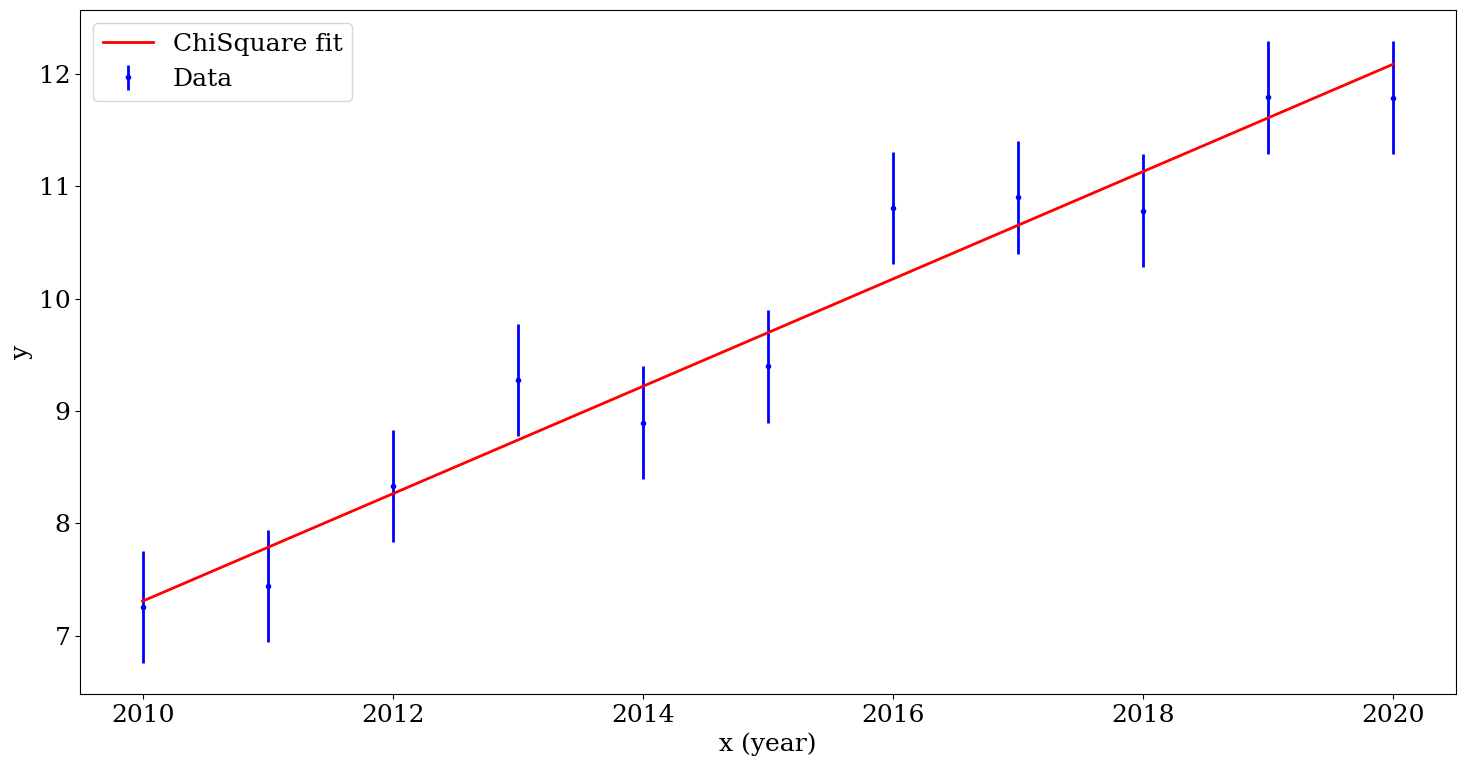

In [8]:
x_fit = np.linspace(minx, maxx, 1000)
y_fit = func_good(x_fit, *minuit_chi2.values[:])

fig, ax = plt.subplots(figsize=(15, 8))
plot_data = ax.errorbar(x, y, sigmay, fmt='.', linewidth=2, color='blue', label="Data")
ax.plot(x_fit, y_fit, '-', color='red', linewidth=2, label='ChiSquare fit')
ax.set(xlabel='x (year)', ylabel='y')
ax.legend()
fig.tight_layout()

---
## CASE 2: Gaussian distribution on a constant background:

The initial fitting function is the following:

* $f_{1}(x) = C+ \frac{N}{\sigma\sqrt(2\pi)}\cdot \exp \left[-0.5 \cdot\left(\frac{(x-\mu)}{\sigma}\right)^{2} \right]$ for $x$ in $[-\infty,\infty]$

It disregards that there might be additional signal peaks at higher values. Your job is to expand the fit until it really describes the data.

In [9]:
Npoints_gauss = 600
mux    = 3.50
sigmax = 0.25
f_core = 0.7

Npoints_pol0 = 2000
minx   =  0.0
maxx   = 10.0
Nbins = 100
binwidth_gauss = (maxx-minx) / float(Nbins)
print(f"  The bin width is: {binwidth_gauss:5.2f}")

  The bin width is:  0.10


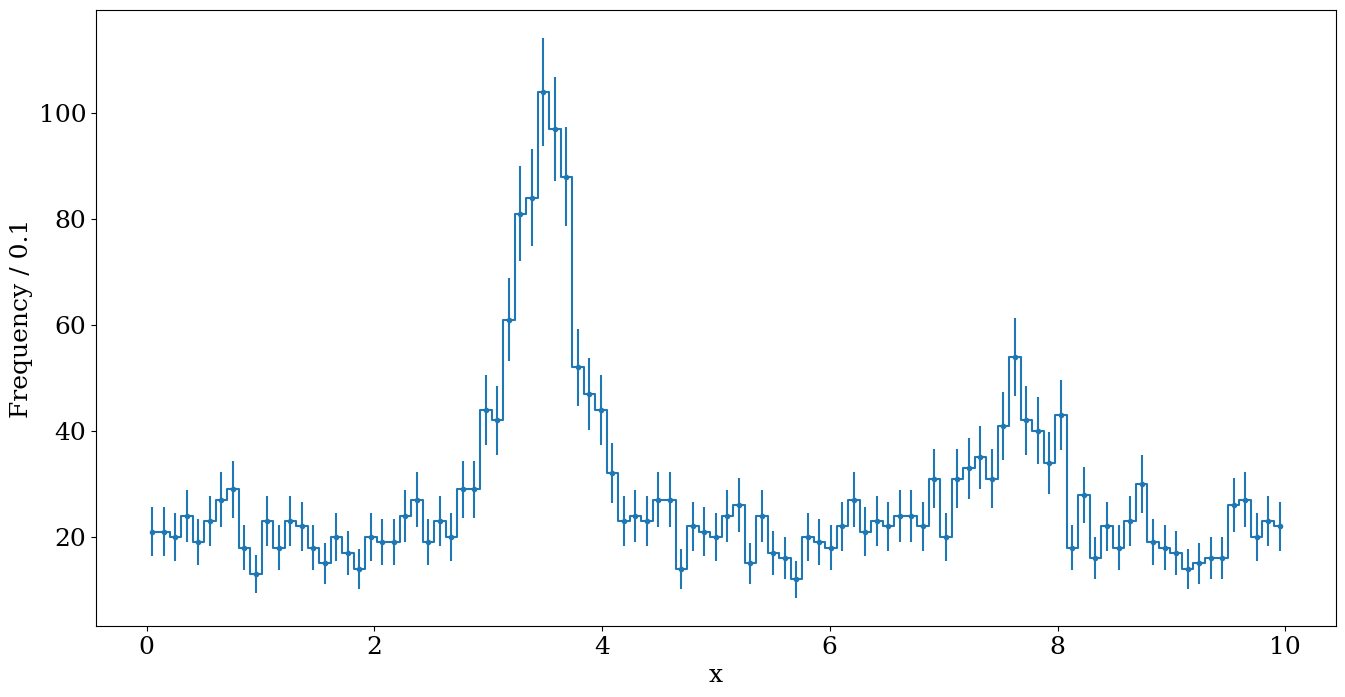

In [10]:
# Fill histogram with signal and background events:
signal1_core = np.random.normal(loc=mux,scale=sigmax,    size=int(Npoints_gauss * f_core))
signal1_tail = np.random.normal(loc=mux,scale=sigmax*2.5,size=int(Npoints_gauss * (1-f_core)))
signal2_core = np.random.normal(loc=mux+4.1,scale=sigmax,    size=int(Npoints_gauss/3.14 * f_core))
signal2_tail = np.random.normal(loc=mux+4.1,scale=sigmax*2.5,size=int(Npoints_gauss/3.14 * (1-f_core)))
bkg = np.random.uniform(low=minx,high=maxx,size=Npoints_pol0)

Y = np.concatenate([signal1_core, signal1_tail, signal2_core, signal2_tail, bkg])
binning = np.linspace(minx,maxx,Nbins)
counts,bin_edges = np.histogram(Y,bins=binning)
unc_count = np.sqrt(counts)
X = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2.

fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(X, counts, yerr=unc_count, marker = '.', drawstyle = 'steps-mid')
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('Frequency / 0.1', fontsize=18);

### Define function (including bin width to get normalisation right):


In [11]:
def func_gpol0(x, N, mu, sigma, cst) :
    norm = binwidth_gauss * N / np.sqrt(2.0*pi) / sigma
    z = (x-mu)/sigma
    return norm * np.exp(-0.5*z*z) + cst

def func_2gauss(x, N_1, mu_1, sigma_1, N_2, mu_2, sigma_2, cst):
    norm_1 = binwidth_gauss * N_1 / np.sqrt(2.0*pi) / sigma_1
    norm_2 = binwidth_gauss * N_2 / np.sqrt(2.0*pi) / sigma_2
    z_1 = (x-mu_1)/sigma_1
    z_2 = (x-mu_2)/sigma_2
    return norm_1 *np.exp(-0.5*z_1*z_1) + norm_2 *np.exp(-0.5*z_2*z_2) + cst

In [12]:
select = counts>0
chi2reg = Chi2Regression(func_gpol0, X[select], counts[select], unc_count[select])
minuit_obj = Minuit(chi2reg, N=50, mu=4, sigma=2.0, cst=20)
minuit_obj.errordef = 1.0
minuit_obj.migrad()   

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 159.1                      │              Nfcn = 150              │
│ EDM = 0.000168 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │    534    │    31     │            │            │         │         │       │
│ 1 │ mu    │   3.489   │   0.018   │            │            │         │         │       │
│ 2 │ sigma │   0.286   │   0.020   │            │            │         │         │       │
│ 3 │ cst   │   21.2    │    0.5    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────┐
│       │        N       mu    sigma      cst │
├───────┼─────────────────────────────────────┤
│     N │      971 -0.00917    0.182    -4.34 │
│    mu │ -0.00917 0.000327 1.45e-05  0.00015 │
│ sigma │    0.182 1.45e-05 0.000407 -0.00151 │
│   cst │    -4.34  0.00015 -0.00151    0.261 │
└───────┴─────────────────────────────────────┘

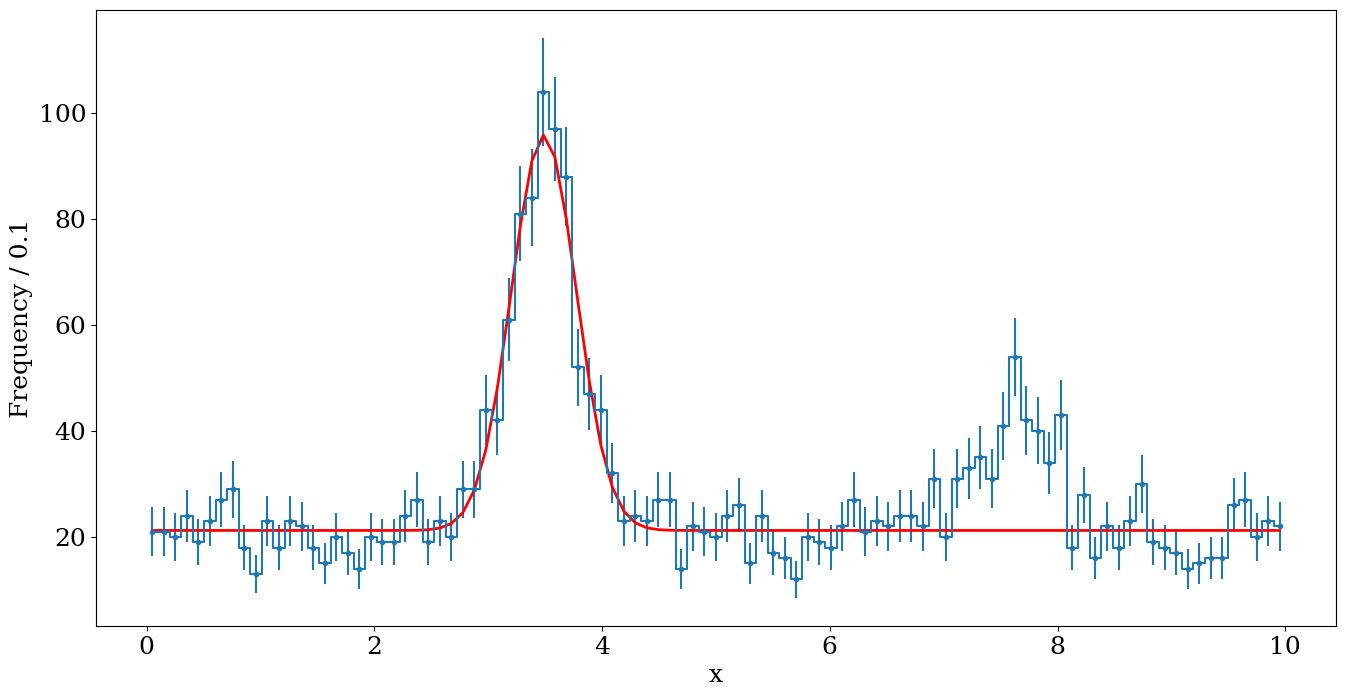

In [13]:
if (not minuit_obj.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

bf_N, bf_mu, bf_sigma, bf_cst = minuit_obj.values[:]
ax.plot(X, func_gpol0(X, bf_N, bf_mu, bf_sigma, bf_cst), 'r', linewidth=2.0, label='Const + Gauss fit')
fig

In [14]:
select = counts>0
chi2reg2 = Chi2Regression(func_2gauss, X[select], counts[select], unc_count[select])
minuit_obj2 = Minuit(chi2reg2, N_1=50, mu_1=4, sigma_1=2.0, N_2 = 40, mu_2 = 7.5, sigma_2 = 2, cst=20)
minuit_obj2.errordef = 1.0
minuit_obj2.migrad()   

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 85.09                      │              Nfcn = 386              │
│ EDM = 2.45e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_1     │    557    │    32     │            │            │         │         │       │
│ 1 │ mu_1    │   3.489   │   0.018   │            │            │         │         │       │
│ 2 │ sigma_1 │   0.297   │   0.019   │            │            │         │         │       │
│ 3 │ N_2     │    187    │    26     │            │            │         │         │       │
│ 4 │ mu_2    │   7.62    │   0.05    │            │            │         │         │       │
│ 5 │ sigma_2 │   0.31    │   0.05    │            │            │         │         │       │
│ 6 │ cst     │   19.9    │    0.6    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────┐
│         │       N_1      mu_1   sigma_1       N_2      mu_2   sigma_2       cst │
├─────────┼───────────────────────────────────────────────────────────────────────┤
│     N_1 │     1e+03  -0.00152     0.224      97.9   -0.0498     0.143     -5.37 │
│    mu_1 │  -0.00152  0.000322 -2.88e-06 -0.000339  1.72e-07 -4.96e-07  1.86e-05 │
│ sigma_1 │     0.224 -2.88e-06  0.000364      0.05 -2.54e-05  7.32e-05  -0.00274 │
│     N_2 │      97.9 -0.000339      0.05       659    -0.239     0.687     -5.68 │
│    mu_2 │   -0.0498  1.72e-07 -2.54e-05    -0.239   0.00233 -0.000981   0.00289 │
│ sigma_2 │     0.143 -4.96e-07  7.32e-05     0.687 -0.000981   0.00255  -0.00831 │
│     cst │     -5.37  1.86e-05  -0.00274     -5.68   0.00289  -0.00831     0.311 │
└─────────┴───────────────────────────────────────────────────────────────────────┘

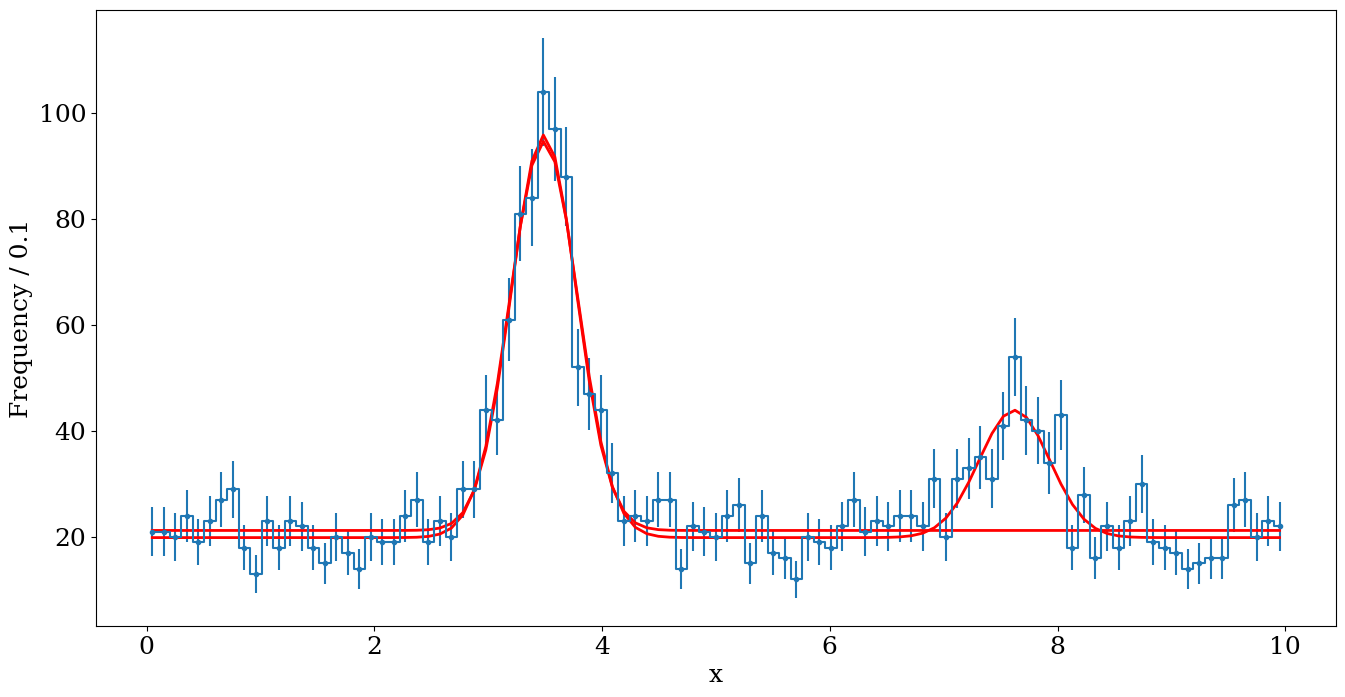

In [15]:
if (not minuit_obj.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")


ax.plot(X, func_2gauss(X, *minuit_obj2.values[:]), 'r', linewidth=2.0, label='Const + Gauss fit')
fig

---

Look at the first case, but make sure that you also do the second case (see below), as this is
at least as important as the first one!

Questions on CASE 2:
--------------------
 1. Look at the data plot and the corresponding fit. What type of fit is it? Does it
    run well (or at all)? And once it runs, does it seem to be reasonable? Why/why not?
    And does the fitting function include all features of the data? Why/why not? Try for
    2-5 minutes and discuss it with others (if possible), before reading on!

---
_2-5 minutes later_...

---

 2. What is the p-value from the minimal Chi2 that your fit obtained, once you got any
    "reasonable" fit to work? Is it acceptable?

 3. As it happens, there are tails on the main peak, and there also seem to be a
    suspectable bump around 7 < x < 8. Try to write
    an expanded fitting function, which includes these features in the model, and get the
    fit to run. How significant is the second Gaussian peak, based on significance of the
    amplitude? And what test would you apply to this, if you wanted to make a full-fledged
    hypothesis test between the two models? Are they nested? Can you actually get a number out?

---
_10-20 minutes later_...

---

 4. Imagine that you concluded that there was a new peak, and that you were sure that
    it had the same width as the original peak (for example because the width was due to
    the resolution of the apperatus, and not the peak itself). Does that help you in the fit,
    and if so, how? Does the significance of the peak increase? Would it always do that?
    Also imagine, that the parameter of interest is the distance between the peaks. How
    would you now write your fitting function?
    

## NOTE: 

If one wanted to test the G+pol0 vs. the G+G+pol0 models against each other, which might be relevant, then considering the difference in ChiSquare values or -2ln of the likelihood ratio would be obvious (these two gives the same result, when errors are Gaussian and the binning does not have any effect). Wilk's theorem would provide the way to produce a p-value, thus doing a proper hypothesis test using the likelihood ratio test:

* Using iminuit, fit the data with both hypothesis, and note the Chi2 or LLH value (usi `minuit_obj.fval`).
* Then compute the test statistic $\chi^2_{1} - \chi^2_{2}$ or $-2\log{\frac{LH_{1}}{LH_{2}}}$, and see that it is $\chi^{2}$ distributed (Wilk's Theorem).

The test statistic distribution will have $N_{dof} = 3$, unless you (smartly) eliminated one parameter from the second fit. The case when fitting with a double Gaussian for each peak is similar.

---
---

## CASE 3: Double exponential distribution

Here we are considering the fitting of exponential data, and how the writing of the fitting function is important.

* The "bad" fitting function:
    $f_{2,bad}(t)  = N_{1}\cdot\exp(-t/r_{1}) + N_{2}\cdot\exp(-t/r_{2})$ for $t$ in $[0,\infty]$

* The "good" fitting function:
    $f_{2,good}(t) = N \cdot\left(\frac{f}{r_{1}}\cdot \exp\left[-t/r_{1}\right] + \frac{(1-f)}{r_{2}}\cdot\exp\left[-t/r_{2}\right]\right)$ for $t$ in $[0,\infty]$

## NOTE
The parameters $r_1$ and $r_2$ need to be positive, and $f$ in [0,1], in order for this to be a PDF.

---

In [16]:
Npoints_2exp = 2000
frac = 0.5   # Fraction that "belongs to" first exponential
r1 = 10.0
r2 =  2.0     # Note to what the two lifetimes are different, as this decides their correlation!
nbins_2exp = 200
xmin_2exp = 0.0
xmax_2exp = 20.0
binning = np.linspace(xmin_2exp, xmax_2exp, nbins_2exp)
binwidth_2exp = (xmax_2exp - xmin_2exp) / nbins_2exp
print(binwidth_2exp)

0.1


In [17]:
all_pts = np.random.uniform(size=Npoints_2exp) 
N1 = sum(all_pts<frac)

t = np.concatenate([np.random.exponential(scale=r1, size=N1),
                    np.random.exponential(scale=r2, size=(Npoints_2exp-N1))])

counts,bin_edges = np.histogram(t, bins=binning)
unc_2exp = np.sqrt(counts)

Text(0, 0.5, 'count')

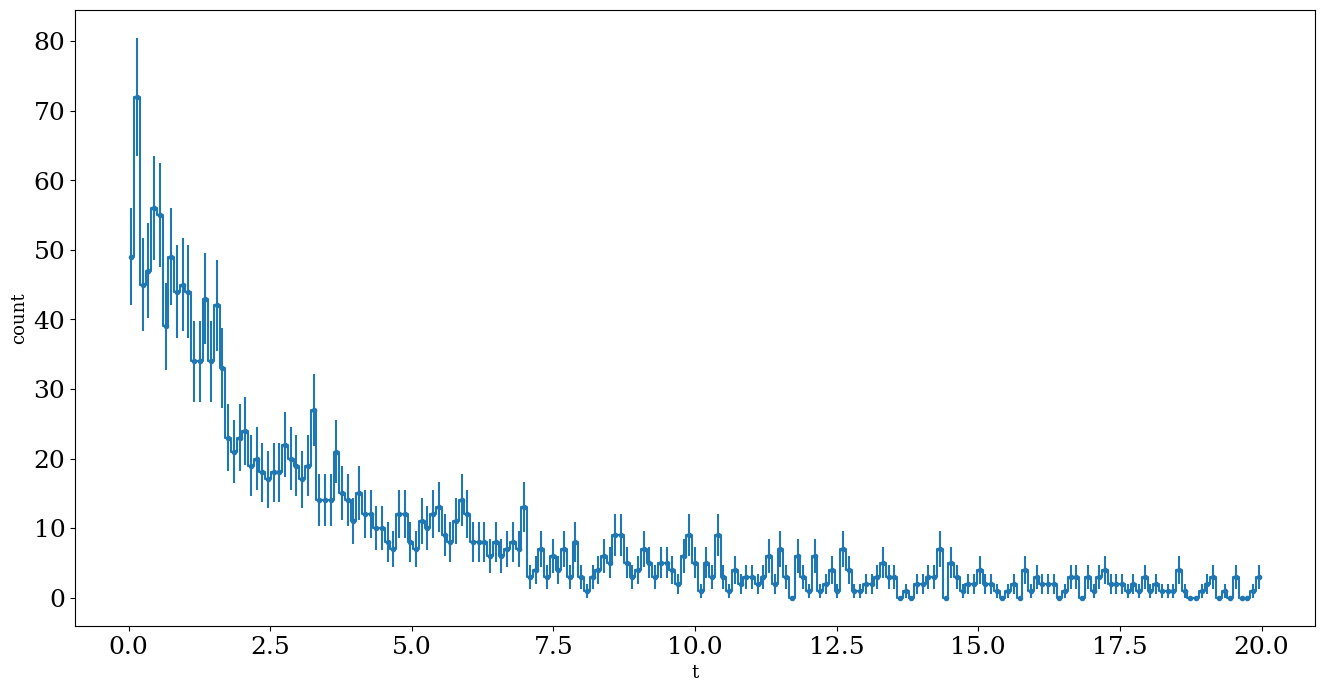

In [18]:
X = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2.

fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(X, counts, yerr=unc_2exp, marker = '.', drawstyle = 'steps-mid')
ax.set_xlabel('t',fontsize=13)
ax.set_ylabel('count',fontsize=13)

### Let's try to fit the data with the bad model:
I include the binwidth (here 0.1) in the fit to ensure that the normalisations are (or could be) right!

In [19]:
def f_2expBad(x,N1,r1,N2,r2):
    binwidth = binwidth_2exp
    return binwidth*(N1*np.exp(-x/r1)+N2*np.exp(-x/r2))

In [20]:
select = counts>0
chi2reg = Chi2Regression(f_2expBad, X[select], counts[select], unc_2exp[select])

# Random starting values:
xf = r.uniform(0.9, 1.1, 4)

# The bad fit (notice that we start it at "perfect" parameters!!!):
minuit_obj = Minuit(chi2reg, N1=xf[0]*frac*Npoints_2exp, r1=xf[1]*r1, N2=xf[2]*(1-frac)*Npoints_2exp, r2=xf[3]*r2)
minuit_obj.errordef = 1.0
minuit_obj.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 239.8                      │              Nfcn = 210              │
│ EDM = 4.17e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N1   │  1.00e3   │  0.14e3   │            │            │         │         │       │
│ 1 │ r1   │   3.52    │   0.18    │            │            │         │         │       │
│ 2 │ N2   │  -0.53e3  │  0.14e3   │            │            │         │         │       │
│ 3 │ r2   │   3.52    │   0.27    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────┐
│    │       N1       r1       N2       r2 │
├────┼─────────────────────────────────────┤
│ N1 │ 1.92e+04    -1.23 -1.9e+04    -1.27 │
│ r1 │    -1.23   0.0314   -0.638    0.046 │
│ N2 │ -1.9e+04   -0.638 1.92e+04   -0.437 │
│ r2 │    -1.27    0.046   -0.437   0.0744 │
└────┴─────────────────────────────────────┘

### Note on the covariance/correlation matrix:

As stated, you want your fit to have the **least** correlations between the fitting parameters.<br>
Try to check all the entries above, and see if you understand why the correlations are as they are.

239.81938366329953 181 0.0022363985449723417


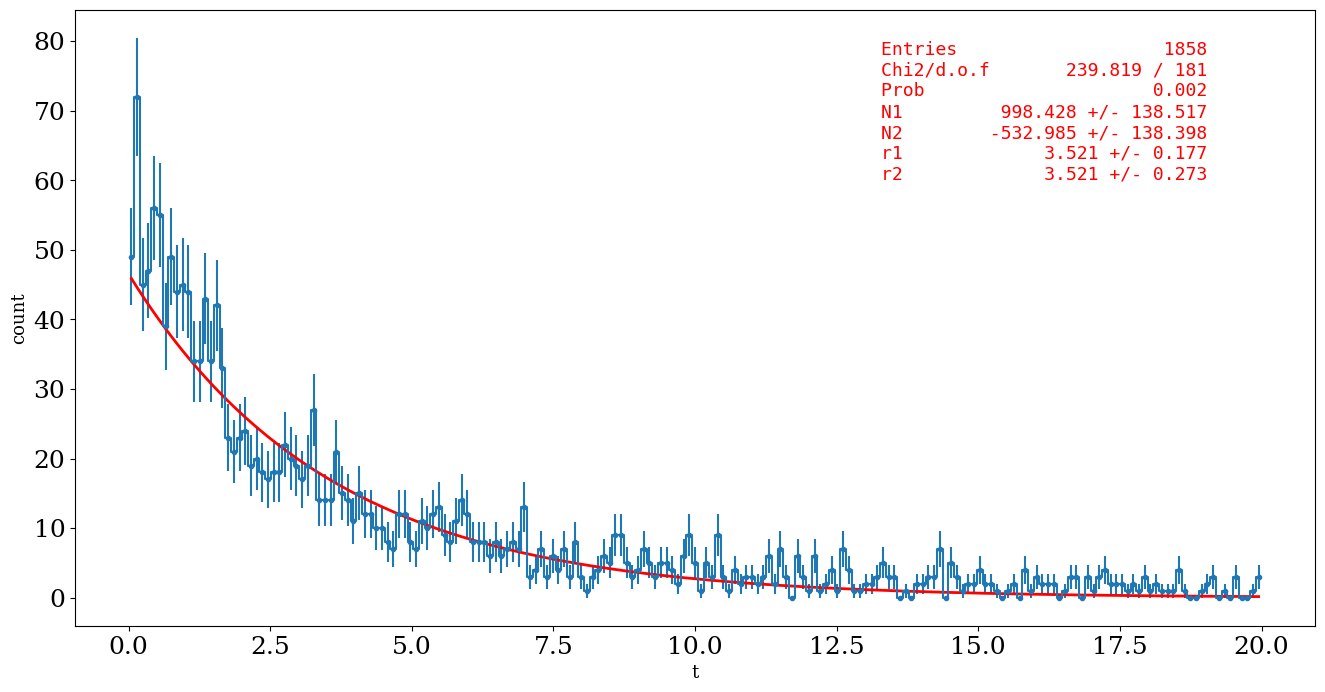

In [21]:
if (not minuit_obj.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")
    
bf_N1, bf_r1, bf_N2, bf_r2 = minuit_obj.values[:]
Chi2 = minuit_obj.fval
Ndof = len(X[select]) - len(minuit_obj.values[:])
ProbChi2 = stats.chi2.sf(Chi2, Ndof)
print(Chi2, Ndof, ProbChi2)

ax.plot(X, f_2expBad(X,bf_N1,bf_r1,bf_N2,bf_r2), 'r', linewidth=2.0, label='Bad fitting function')

d = {'Entries'   : "{:d}".format(sum(counts)),
     'Chi2/d.o.f': "{:.3f} / {:d}".format(Chi2, Ndof),
     'Prob'      : "{:.3f}".format(ProbChi2),
     'N1'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['N1'], minuit_obj.errors['N1']),
     'N2'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['N2'], minuit_obj.errors['N2']),
     'r1'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['r1'], minuit_obj.errors['r1']),
     'r2'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['r2'], minuit_obj.errors['r2'])}

ax.text(0.65, 0.95, nice_string_output(d, 0), family='monospace', 
        transform=ax.transAxes, fontsize=13, color='red', verticalalignment='top')
fig

Questions on CASE 3:
--------------------
 1. Does the "bad" fit work well? Does it extract the parameters used to produce it?
    Can you see what is missing? There are in fact several things, but one is simple to remedy.
    Think and discuss...
   
---
_5-10 minutes later_...

---
Of course you need to give the fit good initial values! Do this (for example those the data was produced with!), and run it again. It might work now, but actually that is not always the case. The reason is that the "bad" fitting function has two flaws:

* It does not have a correct normalisation, thus making N1 and N2 correlated, as well as r1 and r2.
* It does not have one overall normalisation, thus making N1 and N2 even more correlated.

This gives very high correlations between the parameters, as can be seen from the correlation matrix printed.

 2. Both of these problems can be mitigated by rewriting the fitting function to include
    the correct normalisation (i.e. dividing by the lifetime) and by putting only one
    overall normalisation and then dividing the two lifetimes with a fraction (i.e. use
    "frac" and "(1.0-frac)" as a parameter in front of each exponential term).
    Try this (define a "good" function), and see if your fit improves. The way to see
    this would in general be to try a lot of different data, but here we will simply see
    that the correlations are smaller (especially for the overall normalisation).
---
_10-20 minutes later_...

---  

__If you didn't manage to get this fit going, I've included a "good" fitting function below! (but try yourself first!)__

 3. The two lifetimes are naturally very correlated with each other (and the fraction),
    when they are very alike. The only thing one can do about this is to fix one parameter.
    This is of course not desirable, but one can be forced to do it, if the fit does not
    converge otherwise. Note that since the correlation is very high, it is not a great
    loss of freedom in the fitting function. The correlation between r1 and r2 depends a lot
    on how similar they are.
    
    A very common similar example is fitting a "Gaussian-like" peak, which happens to have
    more than one width, for example if the data is obtained from two or more sources with
    different resolutions (as above). Here, one may choose to let the two (or more) Gaussians have
    the same mean, but two different widths (the "good" and the "bad" measurements).
    Typically, the parameter to fix (if any) is the fraction, but never fix a parameter
    without first having tried to let it "float".
    
    However, **no fit function is perfect** and the below fitting function is not an "absolute"
    improvement. The improvement lies only in some parts of the parameter space, and it is hard
    to know, when it has been improved.

### The GOOD fitting function and fit:

In [22]:
def good_exp(x, N, f, r1, r2):
    binwidth = binwidth_2exp

    # Either "just" normalise correctly:
    # return binwidth*(N1/r1*np.exp(-x/r1)+N2/r2*np.exp(-x/r2))
    # Or also re-write to include f = fraction:
    return binwidth*N*(f/r1*np.exp(-x/r1) + (1.0-f)/r2*np.exp(-x/r2))

In [23]:
select = counts>0
chi2reg = Chi2Regression(good_exp, X[select], counts[select], unc_2exp[select])

minuit_obj = Minuit(chi2reg, N=xf[0]*Npoints_2exp, f=xf[3]*frac, r1=xf[1]*r1, r2=xf[2]*r2)
minuit_obj.errordef = 1.0
minuit_obj.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 159.2                      │              Nfcn = 151              │
│ EDM = 2.78e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N    │  1.96e3   │  0.18e3   │            │            │         │         │       │
│ 1 │ f    │   0.371   │   0.029   │            │            │         │         │       │
│ 2 │ r1   │    17     │    10     │            │            │         │         │       │
│ 3 │ r2   │   2.29    │   0.23    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────┐
│    │        N        f       r1       r2 │
├────┼─────────────────────────────────────┤
│  N │ 3.38e+04   -0.346 1.82e+03     31.7 │
│  f │   -0.346 0.000835  -0.0567 -0.00338 │
│ r1 │ 1.82e+03  -0.0567      107     1.96 │
│ r2 │     31.7 -0.00338     1.96   0.0517 │
└────┴─────────────────────────────────────┘

159.22242652989223 181 0.876693383442424


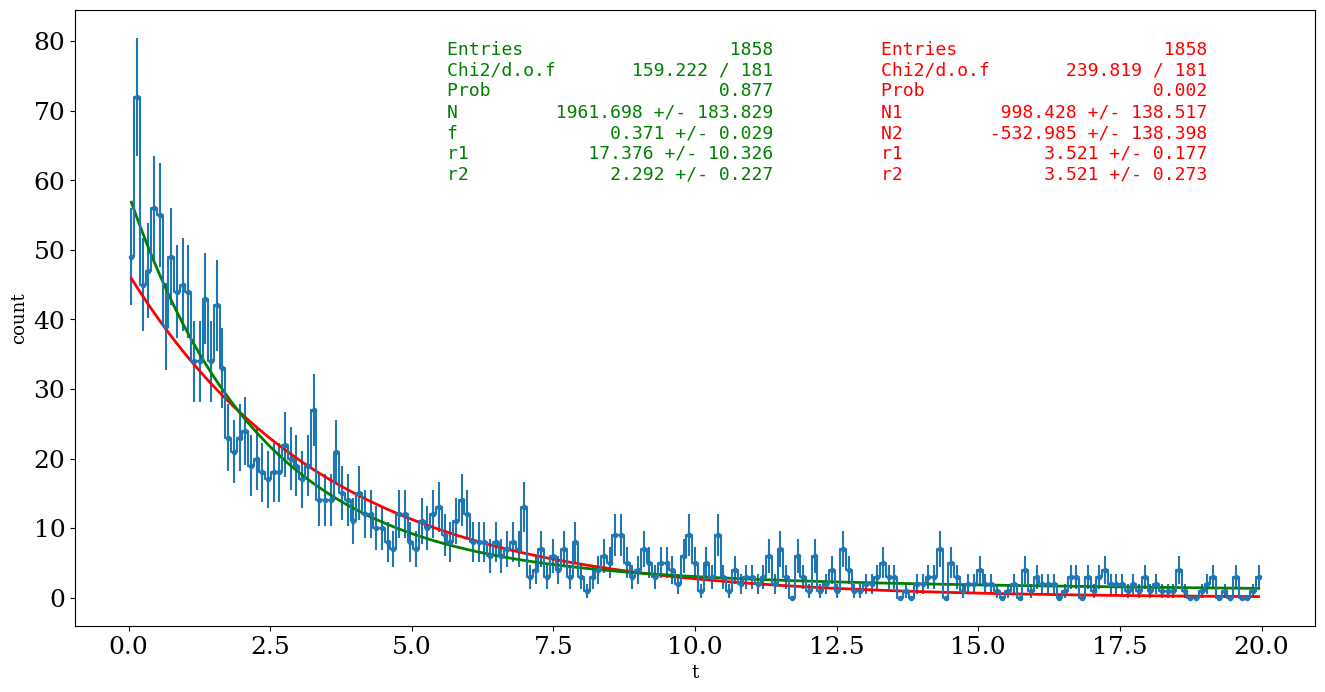

In [24]:
if (not minuit_obj.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

bf_N, bf_f, bf_r1, bf_r2 = minuit_obj.values[:]
Chi2 = minuit_obj.fval
Ndof = len(X[select]) - len(minuit_obj.values[:])
ProbChi2 = stats.chi2.sf(Chi2, Ndof)
print(Chi2, Ndof, ProbChi2)


ax.plot(X, good_exp(X, bf_N, bf_f, bf_r1, bf_r2), 'g', linewidth=2.0, label='Good-fit')

d = {'Entries'   : "{:d}".format(sum(counts)),
     'Chi2/d.o.f': "{:.3f} / {:d}".format(Chi2, Ndof),
     'Prob'      : "{:.3f}".format(ProbChi2),
     'N'         : "{:.3f} +/- {:.3f}".format(minuit_obj.values['N'], minuit_obj.errors['N']),
     'f'         : "{:.3f} +/- {:.3f}".format(minuit_obj.values['f'], minuit_obj.errors['f']),
     'r1'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['r1'], minuit_obj.errors['r1']),
     'r2'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['r2'], minuit_obj.errors['r2'])}

ax.text(0.3, 0.95, nice_string_output(d, 0), family='monospace', 
        transform=ax.transAxes, fontsize=13, color='green', verticalalignment='top')
fig

# Learning points:

This exercise in "fitting tricks" should teach you that:
1. __Good starting values is paramount!__ (Almost all fits fail with poor starting values).
2. The form of the fitting function is also important.<br>
   a. Ensure that the x-values do not represent some small range far from 0.<br>
   b. Ensure that you give the fitting function enough freedom to fit the data.
   c. Conversely, try to curb the number of parameters, if there are arguments for doing so (calibration peaks).
   d. Make sure that you've normalised your fitting PDFs, to avoid correlations between normalisation and parameters.
3. If a fit continues to fail, try simply to draw the function and starting values on top of the data. Often, they don't match well (general advice, not in this exercise).